# GDA

In [1]:
import numpy as np
from autograd import grad
import autograd.numpy as np1
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
import time
from scipy.optimize import BFGS,SR1
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

Optimal solution x: [-1.06410608e+00  4.15929235e-01 -5.35504780e-01  5.42510321e-04]
Optimal value f_mu*: -3.090747151903719
GDA:  2.802809953689575
Optimal solution x: [-1.06284698e+00  4.16025927e-01 -5.38409754e-01  1.77266323e-04]
Optimal value f_mu*: -3.0907319892921845
GDA:  2.778905153274536
Optimal solution x: [-1.06815230e+00  4.16007894e-01 -5.27726969e-01  2.24016640e-04]
Optimal value f_mu*: -3.0907355926911184
GDA:  2.8759562969207764


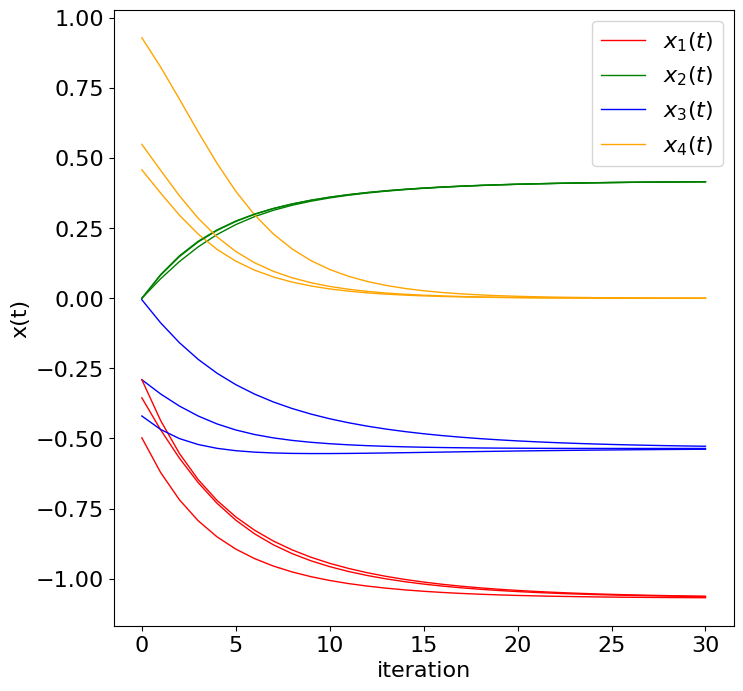

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, BFGS, Bounds
from autograd import grad
import autograd.numpy as anp  # Import autograd.numpy as anp
import time

# Define functions
def ode_solve_G(z0, G, epsi_t, mut, n):
    n_steps = 500
    z = z0
    h = anp.array([0.01])  # Use anp.array instead of np.array
    for i_step in range(n_steps):
        k1 = h * G(z, epsi_t, mut, n)
        k2 = h * (G((z + h/2), epsi_t, mut, n))
        k3 = h * (G((z + h/2), epsi_t, mut, n))
        k4 = h * (G((z + h), epsi_t, mut, n))
        k = (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        z = z + k
    return z

def theta(x, mu):
    if anp.abs(x) >= (mu / 2):  # Use anp.abs instead of np.abs
        return anp.abs(x)
    else:
        return x**2 / mu + mu / 4

def f_mu(x, mu):
    return (anp.exp(theta(x[1] - 3, mu)) - 30) / (x[0]**2 + x[2]**2 + 2*(x[3]**2) + 4)  # Use anp.exp

def f(x):
    return (anp.exp(anp.abs(x[1] - 3)) - 30) / (x[0]**2 + x[2]**2 + 2*(x[3]**2) + 4)  # Use anp.exp and anp.abs

def g1(x):
    return ((x[0] + x[2])**3 + 2*(x[3])**2) - 10

def g2(x):
    return ((x[1] - 1)**2) - 1

def g3(x):
    x = anp.array(x)  # Use anp.array
    A = anp.array([[2, 4, 1, 0]])  # Use anp.array
    b = anp.array([[-1]])  # Use anp.array
    return (A @ (x.T) - b.T).tolist()[0][0]

g1_dx = grad(g1)
g2_dx = grad(g2)
g3_dx = grad(g3)
g_dx = [g1_dx, g2_dx]
f_dx = grad(f)
f_dx_mu = grad(f_mu)
cons = ({'type': 'eq',
         'fun': lambda x: anp.array([g3(x)]),  # Use anp.array
         'jac': lambda x: anp.array([2, 4, 1, 0])},  # Use anp.array
        {'type': 'ineq',
         'fun': lambda x: anp.array([-g1(x)]),  # Use anp.array
         'jac': lambda x: anp.array([-g1_dx(x)])},
        {'type': 'ineq',
         'fun': lambda x: anp.array([-g2(x)]),  # Use anp.array
         'jac': lambda x: anp.array([-g2_dx(x)])})

def rosen(x, y):
    """The Rosenbrock function"""
    return anp.sqrt(anp.sum((x - y)**2))  # Use anp.sqrt and anp.sum

def find_min(y, n):
    x = anp.random.rand(1, n).tolist()[0]  # Use anp.random.rand
    res = minimize(rosen, x, args=(y), jac="2-point", hess=BFGS(),
                   constraints=cons, method='trust-constr', options={'disp': False})
    return res.x

def run_nonsmooth1(x, max_iters, f, f_dx, n, alpha, mu0):
    res = []
    val = []
    lda = 0.1  # Fixed step size
    sigma = 0.1
    mut = mu0
    K = anp.random.rand(1, 1)  # Use anp.random.rand
    res.append(x)
    val.append(f_mu(x, mut))
    x_pre = x
    for t in range(max_iters):
        y = x - lda * f_dx_mu(x, mut)
        x_pre = x.copy()
        x = find_min(y, n)
        if f_mu(x, mut) - f_mu(x_pre, mut) + sigma * (anp.dot(f_dx_mu(x_pre, mut).T, x_pre - x)) <= 0:  # Use anp.dot
            lda = lda
        else:
            lda = K * lda
        mut = mut * anp.exp(-alpha * t)  # Use anp.exp
        res.append(x)
        val.append(f_mu(x, mut))
    
    # Print the optimal solution and optimal value
    optimal_x = res[-1]
    optimal_f_mu = val[-1]
    print(f"Optimal solution x: {optimal_x}")
    print(f"Optimal value f_mu*: {optimal_f_mu}")
    return res, val

def plot_x(sol_all, count, max_iters):
    t = [i for i in range(max_iters + 1)]
    plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 16})
    for i in range(count):
        plt.plot(t, sol_all[i][:, 0], color='red', label=r'$x_{1}(t)$', linewidth=1)
        plt.plot(t, sol_all[i][:, 1], color='green', label=r'$x_{2}(t)$', linewidth=1)
        plt.plot(t, sol_all[i][:, 2], color='blue', label=r'$x_{3}(t)$', linewidth=1)
        plt.plot(t, sol_all[i][:, 3], color='orange', label=r'$x_{4}(t)$', linewidth=1)
    plt.xlabel('iteration')
    plt.ylabel('x(t)')
    plt.legend([r'$x_{1}(t)$', r'$x_{2}(t)$', r'$x_{3}(t)$', r'$x_{4}(t)$'])
    plt.show()

if __name__ == '__main__':
    num = 3  # number of init points
    max_iters = 30  # number of iterations
    max_iters1 = 30
    sol_all, sol_all1 = [], []
    val_all, val_all1 = [], []
    count = 0
    epsilon = 0.1
    mu0 = np.random.rand(1)  # init mu0 
    epsi0 = np.random.rand(1)  # init epsi0
    alpha = np.random.rand(1)  # init alpha
    n = 4  # dimension x
    x_init = np.random.rand(1, n)
    for i in range(num):
        x0 = np.random.rand(1, n)
        x0 = find_min(x0, n)  # init point
        count += 1

        t2 = time.time()
        res1, val1 = run_nonsmooth1(x0, max_iters1, f, f_dx, n, alpha, mu0)
        e2 = time.time()
        print("GDA: ", e2 - t2)
        tmp1 = np.array(res1)[:, :]
        sol_all1.append(tmp1)
        val_all1.append(val1)

    # Plot trajectory
    plot_x(sol_all1, count, max_iters)